The core objects you deal with in resonances are `Simulation`, `Body`, `MMR` (either `ThreeBody` or `TwoBody`), and `SecularResonance` (`GeneralSecularResonance`, `Nu6Resonance`, `Nu5Resonance`, `Nu16Resonance`). All of them are available under the main `namespace` and can be invoked directly.

In [1]:
import resonances

sim = resonances.Simulation()
body = resonances.Body()

If you want to create a mean-motion resonance, you have to specify all integers or use a short notation.

In [2]:
mmr = resonances.ThreeBody([4, -2, -1, 0, 0, -1], ['Jupiter', 'Saturn'])
mmr = resonances.ThreeBody('4J-2S-1')
mmr.to_short()

'4J-2S-1'

The short notation consists of the integers for mean longitudes of planets and an asteroid and the first letters of the chosen planets. For more details, see the paper: *Smirnov, E. A. & Shevchenko, I. I. Massive identification of asteroids in three-body resonances. Icarus 222, 220–228 (2013)*.

There is an ambiguity for Mars and Mercury because both planets have the same first letter. Thus, the app uses the following rule:

- `M` is for Mars.
- `R` is for Mercury.

Actually, the app follows the notation introduced in `mercury` package developed by Chambers (Chambers, 1999).

The order of the planets is natural, from the Sun. So if there are two planets, the first one should be the planet that is closer to the Sun. `4M-2S-1` is correct. `3S-1J-1` is incorrect.

While you can directly specify the type of the resonance (either `TwoBody` or `ThreeBody`), it is recommended to use a special function that detects everything automatically based on the short notation.

In [3]:
mmr = resonances.create_mmr('1J-1')
mmr.to_short()

'1J-1'

In [4]:
mmr = resonances.create_mmr('4J-2S-1')
mmr.to_short()

'4J-2S-1'

Note that the first integer should be positive, as well as they should follow the D'alembert rule (the sum is equal to `0`). Otherwise, you will get an exception:

In [5]:
try:
    mmr = resonances.ThreeBody([4, -2, -1, 0, 0, 0], ['Jupiter', 'Saturn'])
except Exception as exception:
    print(str(exception))
    pass

Sum of integers in a resonance should follow the D'Alembert rule. Given 4, -2, -1, 0, 0, 0, the sum is equal to 1.


You can use `create_resonance` method to create a resonance object, does not matter if it is secular or MMR:

In [2]:
import resonances

mmr = resonances.create_resonance('4J-2S-1')
sec = resonances.create_resonance('nu6')
gsr = resonances.create_resonance('g-g6')

print(mmr.to_s())
print(sec.to_s())
print(gsr.to_s())

4J-2S-1+0+0-1
nu6_Saturn
nu6_Saturn


While this package was created to identify the resonances in the Solar system, one might run such simulations very quickly.

In [6]:
sim = resonances.Simulation()
sim.create_solar_system()

This creates a simulation with the Sun, all planets, and Pluto. Now you can add small bodies. 

## Bodies 

There are two ways how to do that: either manually by specifying all orbital elements or by providing the object's number in the AstDyS catalogue. **Note** that the purpose of supporting the AstDyS catalogue is not to limit a researcher by only numbered asteroids, but to simplify any simulation that studies asteroids. As it is shown below, one can add a custom object (i.e., a TNO) by specifying all the initial data. Please be aware of keeping the consistency across the initial epoch for all bodies added. This should be handled manually by a user.

Note that it is mandatory to specify the resonance for each object (and it should be an instance of `MMR`, not string)!

In [7]:
sim.add_body({'a': 2.0, 'e': 0.1, 'inc': 0.5, 'Omega': 3.0, 'omega': 3.0, 'M': 3.0}, mmr)
sim.add_body('463', mmr, name='Lola')

Note:

1. The names of the variables are exactly the same as they are in `rebound`. There is no need to re-learn anything.
2. All values should be in radians. No degrees. For the AstDyS catalogue, it is done automatically.
3. You may specify the third parameter `name`, which will be used in summaries and plots.

By default, the package uses as initial date the date of AstDyS Catalogue, which is equal at the moment $\mathrm{MJD} = 60400$. This value is stored in Config object: `catalog.date` (for more details, see [the corresponding section](../config)). When you add a body to the simulation, the date is set automatically based on the default value. You can manipulate this config value to set another initial date. However, you would have to adjust all bodies' data to the new epoch. For planets, `rebound` performs this automatically.

Note, if AstDyS catalogue is already downloaded, the package **will not check** whether it is updated. On the contrary, it will use the old version. However, the `astdys` component has a special method `rebuild' that updates the catalogue. Hence, one might use this method for the final run. 

Or you can simply delete the downloaded and converted files...

In [8]:
import astdys

astdys.rebuild()

Cannot find AstDyS catalog. Trying to download it...
Successfully downloaded. Continue working...


It is a good idea to specify before running the simulation what do you want to save. If you do not need figures, it is a good idea to disable them. It will definitely save some time. Also, if you do not need the time series for all asteroids, which can require a lot of space if there are many objects (>1000), then simply disable them.

In [ ]:
sim.save = 'nonzero'  # other options: 'resonant' (only resonant), 'nonzero' (resonant and candidates), None (do not save anything), 'all'
sim.plot = None  # the same as above
sim.plot_type = 'save'  # other options: 'show' (show the plot), 'save' (save the plot), 'both', and None (do not plot anything)

Here I define that I want to save only the resonant asteroids or those that cannot be precisely identified (see [Libration section](../libration); statuses lower than `0`) and do not plot anything.

Please be aware of [default values](../config) — it saves some space for each simulation. There is no need to override if you are OK with them.

You may also want to change the output directory — just rewrite the config `sim.save_path` and `sim.plot_path` after initialisation or make `.env` file or set the environment variable up.

You may add as many objects as you want. However, when the number of asteroids is very high, it might delay the integration process. The usual suggestion is to integrate 100-1000 objects simultaneously, but it depends on the computer's characteristics.

Do not forget to specify the time interval and the number of output points. The default values are good for the resonances in the main belt but not for all possible scenarios. Note that the time used by `rebound` is in years divided to 2π.

In [10]:
sim.config.tmax = 628319
sim.config.Nout = 6283
sim.config.dt = 1.0

When you are ready, just run the simulation by running `sim.run()`.

In [11]:
sim.run()

It might take some time while the app calculates the positions. For the default values (`dt=0.1`), it takes approximately 1-2 minutes. Feel free for testing purposes to increase the time step (`dt=1.0`) or decrease the time interval.

After the `run`, you can access the data. Mostly, they are stored in `Body` objects. There is a list of them in the Simulation object:

In [12]:
for body in sim.bodies:
    print(body.name)

asteroid
Lola


Each Body object has many attributes you might be interested in. The full list is available in the source code. Here I would mention the following:

- `body.angles` — the values of the resonant angles (per MMR) saved per each time step (`sim.Nout` — the number of steps).
- `body.axis` — the values of semi-major axis. — `body.axis_filtered` — the filtered values of semi-major axis.
- `body.ecc` — the values of eccentricity.
- `body.initial_data` — the dictionary of initial data. — `sim.times` — the list of times of integration.

The body object also has information about the librations, frequencies of oscillations and so on (see [Libration module](../libration)).

## Manipulations

Now you can manipulate these objects as you want. For example, you can plot `angle vs time`:

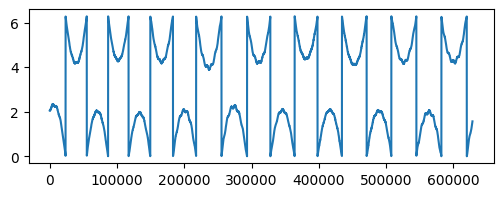

In [16]:
import matplotlib.pyplot as plt

body = sim.bodies[1]
plt.figure(figsize=(6, 2))
plt.plot(sim.times, body.angle(mmr))

It does not look good because `matplotlib` interpolates the breaks. Let us switch them off and also transform time into real years.

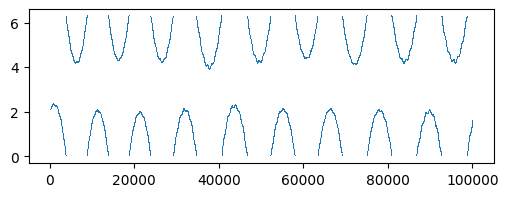

In [17]:
import numpy as np

plt.figure(figsize=(6, 2))
plt.plot(sim.times / (2 * np.pi), body.angle(mmr), linestyle='', marker=',')

Now you might see that the resonant angle librates.

If you enable `plot` option, then the app will create a plot that will contain such resonant angle and some other variables. However, if you need something specific, you can do this by yourself by manipulating `resonances.Simulation` and `resonances.Body` objects.